#### Import field data

In [1]:
from initialisation import *

# Import empirical vegetation density
Vs = {landscape: matrix_to_dict(np.loadtxt('field-data/'+landscape+'/vegetation.asc', skiprows=6)[1:-1,1:-1]/100) for landscape in ['shrubland', 'grassland']}

# Import empirical topography
Ts = {landscape: matrix_to_dict(np.loadtxt('field-data/'+landscape+'/topography.asc', skiprows=6)[1:-1,1:-1]) for landscape in ['shrubland', 'grassland']}

# Import MAHLERAN sediment functional connectivity
FC_star = {landscape: matrix_to_dict(np.loadtxt('MAHLERAN-data/'+landscape+'/sediment-connectivity.asc', skiprows=6)[1:-1,1:-1]) for landscape in ['shrubland', 'grassland']}


#### Initialise lattice

In [4]:
# Create baseline 2D lattice, empirical field data default width=20 and height=60
G_baseline, bulk_nodes = generate_baseline_lattice(20,60)
S, current, branches, new_active, size = declare_simulation_variables(G_baseline)

# Adapt G to shrubland empirical data, assuming probabilistic and deterministic dynamics
G_landscape, propagation_probability, edge_slope, C, SC = {landscape:{} for landscape in ['shrubland', 'grassland']}, {landscape:{} for landscape in ['shrubland', 'grassland']}, {landscape:{} for landscape in ['shrubland', 'grassland']}, {landscape:{} for landscape in ['shrubland', 'grassland']}, {landscape:{} for landscape in ['shrubland', 'grassland']}
for landscape in ['shrubland', 'grassland']:
    for dynamics in ['probabilistic', 'deterministic']:
        G_landscape[landscape][dynamics] = generate_lattice(G_baseline, Ts[landscape], dynamics)
        propagation_probability[landscape][dynamics] = generate_propagation_probabilities(G_landscape[landscape][dynamics], Ts[landscape], dynamics)
        edge_slope[landscape][dynamics] = generate_edge_slopes(G_landscape[landscape][dynamics], Ts[landscape], dynamics)
        print('Preparing node coupling dictionary for '+landscape+' assuming '+dynamics+' dynamics...')
        C[landscape][dynamics] = create_node_coupling_dictionary(G_landscape[landscape][dynamics])
        print('Computing SC on '+landscape+' assuming '+dynamics+' dynamics...')
        SC[landscape][dynamics] = compute_SC(G_landscape[landscape][dynamics], edge_slope[landscape][dynamics])


Preparing node coupling dictionary for shrubland assuming probabilistic dynamics...
Computing SC on shrubland assuming probabilistic dynamics...
Preparing node coupling dictionary for shrubland assuming deterministic dynamics...
Computing SC on shrubland assuming deterministic dynamics...
Preparing node coupling dictionary for grassland assuming probabilistic dynamics...
Computing SC on grassland assuming probabilistic dynamics...
Preparing node coupling dictionary for grassland assuming deterministic dynamics...
Computing SC on grassland assuming deterministic dynamics...


#### Visualisation

Congratulations! You have selected deterministic dynamics on grassland.


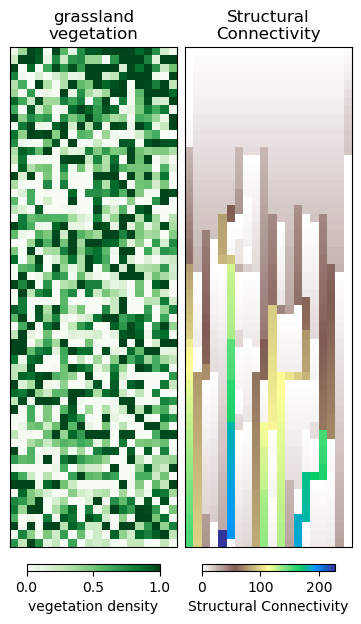

In [ ]:
landscape = int(input('Select the empirical landscape (boolean integer) you want to visualise: 0 for "shrubland", or 1 for "grassland".'))
dynamics = int(input('Select the type of SC dynamics (boolean integer): 0 for "probabilistic routing", or 1 for "deterministic routing"'))

dynamics = 'probabilistic' if dynamics==0 else 'deterministic'
landscape = 'shrubland' if landscape==0 else 'grassland'

print('Congratulations! You have selected '+dynamics+' dynamics on '+landscape+'.')

fig, ax = plt.subplots(1,2, figsize=(3.5,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs[landscape]), cmap='Greens'), ax[1].imshow(dict_to_mat(SC[landscape][dynamics]), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(2)]
_ = [ax[k].set_yticks([]) for k in range(2)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(2)]
_ = ax[0].set_title(landscape+'\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
plt.show()

#### Simulation run

In [6]:
landscape = int(input('Select the emprical landscape (boolean integer): 0 for "shrubland", or 1 for "grassland".'))
dynamics = int(input('Select the type of dynamics (boolean integer): 0 for "probabilistic routing", or 1 for "deterministic routing"'))
nb_runs = int(input('Enter the number of sandpile simulations (integer):'))
nb_steps = (int(input('Enter the number of steps per simulation (integer):'))//100)*100

dynamics = 'probabilistic' if dynamics==0 else 'deterministic'
landscape = 'shrubland' if dynamics==0 else 'grassland'
print('Congratulations! You have selected '+str(nb_runs)+' runs of '+str(nb_steps)+' steps of '+dynamics+' dynamics on '+landscape+'.')


Congratulations! You have selected 20 runs of 40000 steps of deterministic dynamics on grassland.


In [7]:
step_slice = int(nb_steps/100)
SC_FCt, Sizes, FC_cumulated = np.zeros((nb_runs, 100), float), np.zeros(nb_runs, list), {node:0 for node in G_baseline}
for run in range(nb_runs):
    print('Run n°'+str(run+1)+'...')
    S, current_av, branches, active, Sizes[run] = declare_simulation_variables(G_landscape[landscape][dynamics])
    C_run = deepcopy(C[landscape][dynamics])
    for step in range(nb_steps+1):
        S, C_run, current_av, branches, active, Sizes[run] = sandpile_simulation_step(G_landscape[landscape][dynamics], Vs[landscape], propagation_probability[landscape][dynamics], S, C_run, current_av, branches, active, Sizes[run], bulk_nodes)
        if step % step_slice == 0 and step>0:
            FC = compute_FC(C_run)
            SC_FCt[run, int(step/step_slice-1)] = SCFC(SC[landscape][dynamics], FC, bulk_nodes)
    for node in G_baseline:
        FC_cumulated[node] += FC[node]

print('After '+str(nb_runs)+' runs of '+str(nb_steps)+' steps, assuming '+dynamics+' dynamics on '+landscape+',')
print('Average SC-FC correlation: '+str(round(np.mean([SC_FCt[run,-1] for run in range(nb_runs)]),2)))


Run n°1...
Run n°2...
Run n°3...
Run n°4...
Run n°5...
Run n°6...
Run n°7...
Run n°8...
Run n°9...
Run n°10...
Run n°11...
Run n°12...
Run n°13...
Run n°14...
Run n°15...
Run n°16...
Run n°17...
Run n°18...
Run n°19...
Run n°20...
After 20 runs of 40000 steps, assuming deterministic dynamics on grassland,
Average SC-FC correlation: 0.73


#### Visualisation

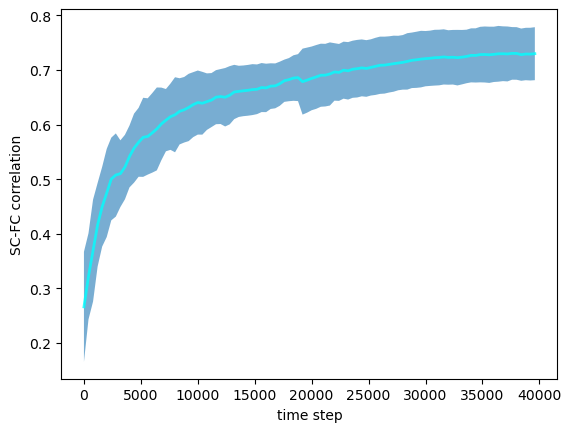

In [8]:
step_arange = np.arange(1, nb_steps+1, step_slice)
SCFC_avg = np.array([np.mean([SC_FCt[run,k] for run in range(nb_runs)]) for k in range(100)])
SCFC_std = np.array([np.std([SC_FCt[run,k] for run in range(nb_runs)]) for k in range(100)])

plt.fill_between(step_arange, SCFC_avg-SCFC_std, SCFC_avg+SCFC_std, alpha=.6)
plt.plot(step_arange, SCFC_avg, lw=2, color='cyan', alpha=.8)
plt.xlabel('time step')
plt.ylabel('SC-FC correlation')
plt.show()

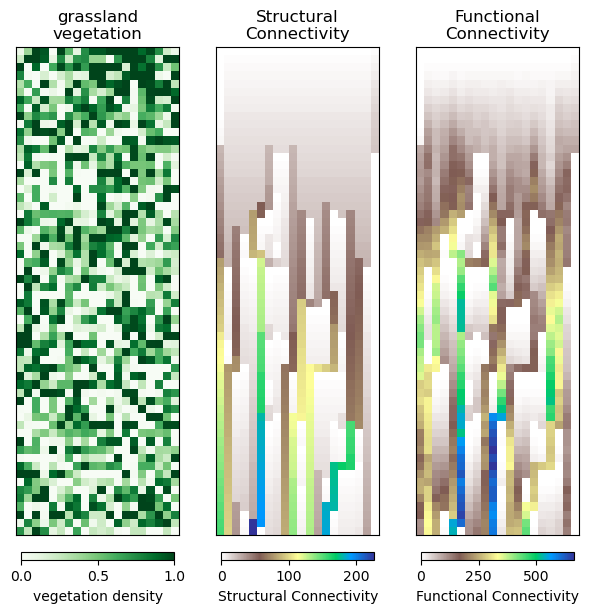

In [9]:
fig, ax = plt.subplots(1,3, figsize=(6,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs[landscape]), cmap='Greens'), ax[1].imshow(dict_to_mat(SC[landscape][dynamics]), cmap='terrain_r'), ax[2].imshow(dict_to_mat(FC_cumulated), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(3)]
_ = [ax[k].set_yticks([]) for k in range(3)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(3)]
_ = ax[0].set_title(landscape+'\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
_ = ax[2].set_title('Functional\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
cbar[2].set_label('Functional Connectivity')
plt.show()

#### Avalanche size analysis

In [ ]:

def drop_zeros(a_list):
    return a_list[~np.isnan(a_list)]

def log_binning_with_input(counter_dict, overall_binning):
    bin_means_y = np.histogram(list(counter_dict.keys()), bins=overall_binning, weights=list(counter_dict.values()))[0] / np.histogram(list(counter_dict.keys()), bins=overall_binning)[0]
    bin_means_x = np.histogram(list(counter_dict.keys()), bins=overall_binning, weights=list(counter_dict.keys()))[0] / np.histogram(list(counter_dict.keys()), bins=overall_binning)[0]
    return bin_means_x, bin_means_y


In [24]:
# Aggregate all the recorded avalanche sizes into a single list
all_sizes = sum(Sizes, [])

# Compute the scaling parameter α and the cut-off parameter x_0 for each simulation run
fit = powerlaw.Fit(all_sizes, xmin=2)
scaling_parameter, cutoff_parameter = fit.truncated_power_law.parameter1, fit.truncated_power_law.parameter2

print('Scaling parameter =', scaling_parameter)
print('Cut-off parameter =', cutoff_parameter)

Scaling parameter = 1.3210657345767576
Cut-off parameter = 0.11731448562117963


#### Visualisation

C:\Users\selim\AppData\Local\Temp\ipykernel_24708\87050157.py:17: RuntimeWarning: invalid value encountered in divide
  bin_means_y = np.histogram(list(counter_dict.keys()), bins=overall_binning, weights=list(counter_dict.values()))[0] / np.histogram(list(counter_dict.keys()), bins=overall_binning)[0]
C:\Users\selim\AppData\Local\Temp\ipykernel_24708\87050157.py:18: RuntimeWarning: invalid value encountered in divide
  bin_means_x = np.histogram(list(counter_dict.keys()), bins=overall_binning, weights=list(counter_dict.keys()))[0] / np.histogram(list(counter_dict.keys()), bins=overall_binning)[0]


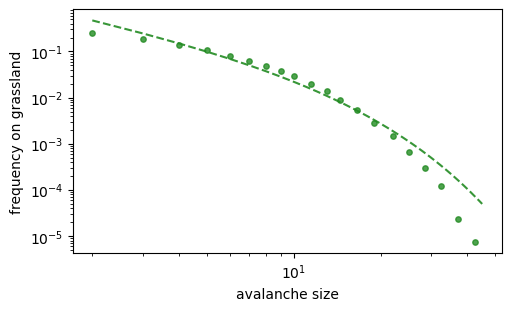

In [25]:
# Identifying the largest avalanche to be used as reference for binning the avalanche size distribution
binning_ref = np.logspace(0, log10(max(all_sizes)), 30)
bx, by = log_binning_with_input(Counter(all_sizes), binning_ref)
bx, by = drop_zeros(bx), drop_zeros(by)

color = 'forestgreen' if landscape=='grassland' else 'sandybrown'

plt.figure(figsize=(5,3), constrained_layout=True)
plt.scatter(bx, by/sum(by), marker='.', color=color, alpha=.8, s=60, label=landscape)
fit.truncated_power_law.plot_pdf(color=color, linestyle='--', alpha=.9)
plt.xlabel('avalanche size')
plt.ylabel('frequency on '+landscape)
plt.show()
